Install/Import the required libraries

In [1]:
from __future__ import absolute_import, division, print_function
import pickle
import gzip
import shutil
import pandas as pd
import cv2
from functools import reduce
from torch.nn.functional import adaptive_avg_pool2d
from torch.autograd import Variable
import imageio
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch
import PIL
from PIL import Image
from os import path
import os.path
from tqdm import tqdm
import warnings
import urllib
import pathlib
from scipy import linalg
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import sys
print("Python version")
print(sys.version)
print("Version info.")
print(sys.version_info)

!{sys.executable} - m pip install - -upgrade pip
!{sys.executable} - m pip install numpy
!{sys.executable} - m pip install pandas
!{sys.executable} - m pip install tensorflow_addons
!pip install PyDrive
! gdown - -id 11dzPv9LxegCDJTNE0RVCJD9hi2sxjQb4
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download - c gan-getting-started
! unzip gan-getting-started

try:
    from kaggle_datasets import KaggleDatasets
except:
    pass
try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: photo_jpg/46e71a4094.jpg  
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  

#Connecting to the TPU 

In [2]:
try:
    # Get the TPU address
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu_resolver.master())
except ValueError:
    tpu_resolver = None

if tpu_resolver:
    # Connecting to the TPU
    tf.config.experimental_connect_to_cluster(tpu_resolver)
    # TPU initialisazion
    tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
    # TPU's trategy instanciation
    strategy = tf.distribute.TPUStrategy(tpu_resolver)

else:
    strategy = tf.distribute.get_strategy()
# Show replica number
print("REPLICAS: ", strategy.num_replicas_in_sync)

# Set AUTOTUNE variable for optimization
AUTOTUNE = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.110.3.34:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.110.3.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.110.3.34:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


Set BATCH_SIZE and STEPS_PER_EPOCH variables xdepending on the available accelerator

In [3]:
PHOTO_DATASET_SIZE = 7028

if tpu_resolver:
    BATCH_SIZE = 1024*strategy.num_replicas_in_sync
    STEPS_PER_EPOCH = (PHOTO_DATASET_SIZE // BATCH_SIZE + 1)*10
else:
    BATCH_SIZE = 32
    STEPS_PER_EPOCH = (PHOTO_DATASET_SIZE // BATCH_SIZE + 1)*10

#Data loading and preprocessing

Creating filepaths for accessing TFRecord (Tensorflow Records) format data

In [9]:
datafolder = 'gs://kds-f92a403ee980ccc7a30231df6dbde8f34a5499587cfdfc603457086b'
#datafolder = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(datafolder + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(datafolder + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


Functions to decode image from TFRecord to JPEG format and to load an image-dataset

In [10]:
IMAGE_SIZE = [256, 256]


def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image


def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Showing some samples of images

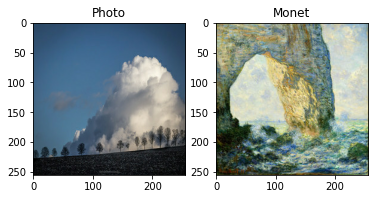

In [11]:
monet_ds = load_dataset(MONET_FILENAMES).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES).batch(1)
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

Loading and preparing dataset function

In [12]:
def get_gan_dataset(monet_files, photo_files, repeat=True, shuffle=True, batch_size=1, nb_repeat=None):
    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)

    # Dédouble les datatasets
    if repeat:
        monet_ds = monet_ds.repeat(nb_repeat)
        photo_ds = photo_ds.repeat(nb_repeat)

    # Mélange les datasets
    if shuffle:
        monet_ds = monet_ds.shuffle(512, 2, True)
        photo_ds = photo_ds.shuffle(512, 2, True)

    # batchage des datasets
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)

    # Pré-extraction d'un nombre "AUTOTUNE" de batchs
    monet_ds = monet_ds.prefetch(AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)

    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    return gan_ds

Creating final dataset

In [13]:
final_dataset = get_gan_dataset(
    MONET_FILENAMES, PHOTO_FILENAMES, repeat=True, shuffle=False, batch_size=64)

#CycleGAN Building

Convolution layers building function

In [14]:
OUTPUT_CHANNELS = 3


def down_sample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2D(filters, size, strides=2, padding='same',
              kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        layer.add(tfa.layers.InstanceNormalization(
            gamma_initializer=gamma_init))

    layer.add(layers.LeakyReLU())

    return layer

Transpose convolution layers building function

In [15]:
def up_sample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2DTranspose(filters, size, strides=2,
              padding='same', kernel_initializer=initializer, use_bias=False))
    layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        layer.add(layers.Dropout(0.5))

    layer.add(layers.ReLU())

    return layer

Generator building function

In [16]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    down_stack = [
        down_sample(64, 4, apply_instancenorm=False),
        down_sample(128, 4),
        down_sample(256, 4),
        down_sample(512, 4),
        down_sample(512, 4),
        down_sample(512, 4),
        down_sample(512, 4),
        down_sample(512, 4),
    ]

    up_stack = [
        up_sample(512, 4, apply_dropout=True),
        up_sample(512, 4, apply_dropout=True),
        up_sample(512, 4, apply_dropout=True),
        up_sample(512, 4),
        up_sample(256, 4),
        up_sample(128, 4),
        up_sample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(
        3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

Discriminator building function for Monet Paint.

This kind of discriminator does not include the last layer as it is trained separately for each Discriminator of the dual discriminator

In [17]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    down1 = down_sample(64, 4, False)(x)
    down2 = down_sample(128, 4)(down1)
    down3 = down_sample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(
        512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(
        gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    return tf.keras.Model(inputs=inp, outputs=zero_pad2)

Ths function is creating the last layer (the missing one of the previons function) for a discriminator building with the previous function. This structure enable to use the same first layers for the Discriminator 1 and 2 and to specialize the last layer for each binary classification :
* Is a real peinture
* Is a generated peinture


In [18]:
def DHead():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[33, 33, 512], name='input_image')
    x = inp

    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(
        x)  # (size, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

Discriminator building function for real photo

In [19]:
def DiscriminatorP():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    down1 = down_sample(64, 4, False)(x)
    down2 = down_sample(128, 4)(down1)
    down3 = down_sample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(
        512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(
        gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(
        1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

CycleGAN building class definition

In [20]:
class CycleGan(keras.Model):
    # Executed function at the instanciation time
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        dhead1,
        dhead2,
        lambda_cycle=3,
        lambda_id=3,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_id = lambda_id
        self.dhead1 = dhead1
        self.dhead2 = dhead2

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn1,
        gen_loss_fn2,
        disc_loss_fn1,
        disc_loss_fn2,
        cycle_loss_fn,
        identity_loss_fn,
        aug_fn,

    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn1 = gen_loss_fn1
        self.gen_loss_fn2 = gen_loss_fn2
        self.disc_loss_fn1 = disc_loss_fn1
        self.disc_loss_fn2 = disc_loss_fn2
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.aug_fn = aug_fn

        self.step_num = 0

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        batch_size = tf.shape(real_monet)[0]

        with tf.GradientTape(persistent=True) as tape:

            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Diffaugment
            both_monet = tf.concat([real_monet, fake_monet], axis=0)

            aug_monet = self.aug_fn(both_monet)

            aug_real_monet = aug_monet[:batch_size]
            aug_fake_monet = aug_monet[batch_size:]

            # two-objective discriminator
            disc_fake_monet1 = self.dhead1(self.m_disc(
                aug_fake_monet, training=True), training=True)
            disc_real_monet1 = self.dhead1(self.m_disc(
                aug_real_monet, training=True), training=True)
            disc_fake_monet2 = self.dhead2(self.m_disc(
                aug_fake_monet, training=True), training=True)
            disc_real_monet2 = self.dhead2(self.m_disc(
                aug_real_monet, training=True), training=True)

            monet_gen_loss1 = self.gen_loss_fn1(disc_fake_monet1)
            monet_disc_loss1 = self.disc_loss_fn1(
                disc_real_monet1, disc_fake_monet1)
            monet_gen_loss2 = self.gen_loss_fn2(disc_fake_monet2)
            monet_disc_loss2 = self.disc_loss_fn2(
                disc_real_monet2, disc_fake_monet2)

            monet_gen_loss = (monet_gen_loss1 + monet_gen_loss2) * 0.4
            monet_disc_loss = monet_disc_loss1 + monet_disc_loss2

            # discriminator used to check, inputing real images
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            photo_gen_loss = self.gen_loss_fn1(disc_fake_photo)

            # evaluates discriminator loss
            photo_disc_loss = self.disc_loss_fn1(
                disc_real_photo, disc_fake_photo)

            # evaluates total generator loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle / tf.cast(
                batch_size, tf.float32)) + self.cycle_loss_fn(
                real_photo, cycled_photo, self.lambda_cycle / tf.cast(batch_size, tf.float32))

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + \
                self.identity_loss_fn(
                    real_monet, same_monet, self.lambda_id / tf.cast(batch_size, tf.float32))
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + \
                self.identity_loss_fn(
                    real_photo, same_photo, self.lambda_id / tf.cast(batch_size, tf.float32))

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(
            total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(
            total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Heads gradients
        monet_head_gradients = tape.gradient(monet_disc_loss1,
                                             self.dhead1.trainable_variables)

        self.m_disc_optimizer.apply_gradients(zip(monet_head_gradients,
                                                  self.dhead1.trainable_variables))

        monet_head_gradients = tape.gradient(monet_disc_loss2,
                                             self.dhead2.trainable_variables)

        self.m_disc_optimizer.apply_gradients(zip(monet_head_gradients,
                                                  self.dhead2.trainable_variables))

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            'total_monet_gen_loss': total_monet_gen_loss,
            'total_photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'monet_disc_loss1': monet_disc_loss1,
            'monet_disc_loss2': monet_disc_loss2,
            'photo_disc_loss': photo_disc_loss,
        }

#Loss functions definition

Discriminator Loss function :
* discriminator_loss1 is used for "is real photo" and "is real peinture" discriminators
* discriminator_loss2 is used for "is generated peinture" discriminator

In [21]:
with strategy.scope():
    def discriminator_loss1(real, generated):
        real_loss = tf.math.minimum(
            tf.zeros_like(real), real-tf.ones_like(real))

        generated_loss = tf.math.minimum(tf.zeros_like(
            generated), -generated-tf.ones_like(generated))

        total_disc_loss = real_loss + generated_loss

        return tf.reduce_mean(-total_disc_loss * 0.5)

    def discriminator_loss2(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return tf.reduce_mean(total_disc_loss * 0.5)

Generator Loss function :
* generator_loss1 is used for "fake photo" and "fake peinture" generators
* generator_loss2 is used for "fake peinture" generator

In [22]:
with strategy.scope():
    def generator_loss1(generated):
        return tf.reduce_mean(-generated)

    def generator_loss2(generated):
        return tf.reduce_mean(tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated))

calc_cycle_loss function is used for calculating the cycle consistency loss between an original image and its cycled image. Cycled image is :
* for a real peinture, cycled peinture = PeintureGenerator(PhotoGenerator(original peinture))
* for a real photo, cycled photo = PhotoGenerator(PeintureGenerator(original photo))

In [23]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_sum(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1 * 0.0000152587890625

identity_loss function is used for forcing the Generator to not change an image if not nedd. For instance:
* PhotoGenerator should not modify a photo at all (idealy) -> PhotoGenerator(original photo) ~ original photo 
* PeintureGenerator should not modify a photo at all (idealy) -> PeintureGenerator(original peinture) ~ original peinture

In [24]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_sum(tf.abs(real_image - same_image))

        return LAMBDA * 0.5 * loss * 0.0000152587890625

#Data-Augmentation functions

In [25]:
with strategy.scope():
    # General Data-Augmentation calling function
    def DiffAugment(x, policy='', channels_first=False):
        if policy:
            if channels_first:
                x = tf.transpose(x, [0, 2, 3, 1])
            for p in policy.split(','):
                for f in AUGMENT_FNS[p]:
                    x = f(x)
            if channels_first:
                x = tf.transpose(x, [0, 3, 1, 2])
        return x

    # Random modification of brightness

    def rand_brightness(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
        x = x + magnitude
        return x

    # Random modification of saturation
    def rand_saturation(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
        x_mean = tf.reduce_sum(x, axis=3, keepdims=True) * \
            0.3333333333333333333
        x = (x - x_mean) * magnitude + x_mean
        return x

    # Random modification of contraste
    def rand_contrast(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
        x_mean = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True) * 5.086e-6
        x = (x - x_mean) * magnitude + x_mean
        return x

    # Image random translation
    def rand_translation(x, ratio=0.125):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        shift = tf.cast(tf.cast(image_size, tf.float32)
                        * ratio + 0.5, tf.int32)
        translation_x = tf.random.uniform(
            [batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
        translation_y = tf.random.uniform(
            [batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
        grid_x = tf.clip_by_value(tf.expand_dims(tf.range(
            image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
        grid_y = tf.clip_by_value(tf.expand_dims(tf.range(
            image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
        x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(
            grid_x, -1), batch_dims=1)
        x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [
                         1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
        return x

    # Image random cutout
    def rand_cutout(x, ratio=0.5):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        cutout_size = tf.cast(
            tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        offset_x = tf.random.uniform([tf.shape(
            x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
        offset_y = tf.random.uniform([tf.shape(
            x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
        grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(
            cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
        cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] //
                               2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
        mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
        cutout_grid = tf.maximum(cutout_grid, 0)
        cutout_grid = tf.minimum(
            cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
        mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones(
            [batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
        x = x * tf.expand_dims(mask, axis=3)
        return x

    # Dictionnaire des méthodes de data augmentation
    AUGMENT_FNS = {
        'color': [rand_brightness, rand_saturation, rand_contrast],
        'translation': [rand_translation],
        'cutout': [rand_cutout],
    }

    # Fonction intermédiaire d'appel de la fonction de data augmentation
    def aug_fn(image):
        return DiffAugment(image, "color,translation,cutout")

function for loop training 

In [32]:
def Cycle_GAN_training_function(learning_rate_array, number_epoch_array, photo_files_path, earlystop_patience=None):

    # Creating dataset for test generation
    photo_ds = load_dataset(photo_files_path).batch(1)

    # Variable for saving the Loss performance
    loss_results_df_total = pd.DataFrame()

    # Defining callback function
    earlystop = keras.callbacks.EarlyStopping(
        monitor='total_monet_gen_loss',
        min_delta=0.001,
        patience=earlystop_patience,
        verbose=1,
        mode='min'
    )

    with strategy.scope():
        monet_generator = Generator()  # transforms photos to Monet-esque paintings
        photo_generator = Generator()  # transforms Monet paintings to be more like photos

        # differentiates real Monet paintings and generated Monet paintings
        monet_discriminator = Discriminator()
        # differentiates real photos and generated photos
        photo_discriminator = DiscriminatorP()

        dHead1 = DHead()  # Head for BCE
        dHead2 = DHead()  # Head for hinge loss

        # Instanciate the CycleGAN with the generators and the discriminators
        cycle_gan_model = CycleGan(
            monet_generator, photo_generator, monet_discriminator, photo_discriminator, dHead1, dHead2
        )

    # loop training throughout the various learning rate
    for i in np.arange(len(learning_rate_array)):
        with strategy.scope():
            # Update the optimizer with the new learning rate
            monet_generator_optimizer = tf.keras.optimizers.Adam(
                learning_rate_array[i], beta_1=0.5)
            photo_generator_optimizer = tf.keras.optimizers.Adam(
                learning_rate_array[i], beta_1=0.5)
            monet_discriminator_optimizer = tf.keras.optimizers.Adam(
                learning_rate_array[i], beta_1=0.5)
            photo_discriminator_optimizer = tf.keras.optimizers.Adam(
                learning_rate_array[i], beta_1=0.5)

            # Compiling the model with the new optimizer
            cycle_gan_model.compile(
                m_gen_optimizer=monet_generator_optimizer,
                p_gen_optimizer=photo_generator_optimizer,
                m_disc_optimizer=monet_discriminator_optimizer,
                p_disc_optimizer=photo_discriminator_optimizer,
                gen_loss_fn1=generator_loss1,
                gen_loss_fn2=generator_loss2,
                disc_loss_fn1=discriminator_loss1,
                disc_loss_fn2=discriminator_loss2,
                cycle_loss_fn=calc_cycle_loss,
                identity_loss_fn=identity_loss,
                aug_fn=aug_fn
            )

        # Add earlystop callback whether an earlystop_patience has been given or not
        if earlystop_patience == None:
            history = cycle_gan_model.fit(
                final_dataset, steps_per_epoch=STEPS_PER_EPOCH, epochs=number_epoch_array[i])
        else:
            history = cycle_gan_model.fit(
                final_dataset, steps_per_epoch=STEPS_PER_EPOCH, epochs=number_epoch_array[i], callbacks=[earlystop])

        # Plot some samples to see how the training performed
        _, ax = plt.subplots(5, 2, figsize=(32, 32))
        for i, img in enumerate(photo_ds.take(5)):
            prediction = monet_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input Photo")
            ax[i, 1].set_title("Monet-esque")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")
        plt.show()

        # Compute and save Loss
        loss_results_df = pd.DataFrame(history.history)
        loss_results_df = loss_results_df.applymap(np.mean)
        loss_results_df_total = pd.concat(
            [loss_results_df_total, loss_results_df], ignore_index=True)

        # Increment indice i for looping through the learning_rate_array and number_epoch_array
        i += 1

    # Plot the various Loss
    plt.plot(loss_results_df_total.index,
             loss_results_df_total['total_monet_gen_loss'], color='g', label='Loss Monet Generator')
    plt.plot(loss_results_df_total.index,
             loss_results_df_total['total_photo_gen_loss'], color='r', label='Loss Photo Generator')
    plt.plot(loss_results_df_total.index,
             loss_results_df_total['monet_disc_loss'], color='b', label='Loss Monet Discriminator')
    plt.plot(loss_results_df_total.index,
             loss_results_df_total['photo_disc_loss'], color='m', label='Loss Photo Discriminator')

    for x_axis in number_epoch_array[:len(number_epoch_array)-2]:
        plt.axvline(x=x_axis, color='k')

    plt.legend()
    plt.show()

    # Saving the weights of the :
    # * Photo Generator and Discriminator
    # * Peinture Generator and Discriminator
    cycle_gan_model.p_gen.save_weights("p_gen_weights.h5")
    cycle_gan_model.p_disc.save_weights("p_disc_weights.h5")
    cycle_gan_model.m_gen.save_weights("m_gen_weights.h5")
    cycle_gan_model.m_disc.save_weights("m_disc_weights.h5")

    # When looping is finished return the total saved Loss
    return monet_generator

Definne variables fortraining and strat Cycle_GAN_training_function

In [33]:
% % time
#learning_rate_array = [2e-4,1e-4,5e-5,2.5e-5,1e-5]
#number_epoch_array = [200,200,200,200,200]
#number_epoch_array = [200,150,100,50,25]
learning_rate_array = [2e-4, 1e-4, 1e-5]
number_epoch_array = [300, 200, 100]
#learning_rate_array = [2e-4,1e-4,1e-5]
#number_epoch_array = [10,10,10]
#learning_rate_array = [1e-4]
#number_epoch_array = [10]
#learning_rate_array = [2e-4,1e-4,5e-5,2.5e-5,1e-5]
#number_epoch_array = [400,400,400,400,400]

loss_results_df_total = pd.DataFrame()

final_monet_generator = Cycle_GAN_training_function(
    learning_rate_array, number_epoch_array, PHOTO_FILENAMES, earlystop_patience=None)

Output hidden; open in https://colab.research.google.com to view.

Creating the fake peintures and saving them into the "../images/" folder

In [ ]:
% % time
! mkdir images
! mkdir ../images
# Création d'un batch de photos dédié à la génération du fichier à soumettre
fast_photo_ds = load_dataset(PHOTO_FILENAMES).batch(
    32*strategy.num_replicas_in_sync).prefetch(32*strategy.num_replicas_in_sync)
i = 1
for img in fast_photo_ds:
    prediction = final_monet_generator(img, training=False).numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    for pred in prediction:
        im = PIL.Image.fromarray(pred)
        im.save("../images/" + str(i) + ".jpg")
        i += 1

Creating the zip archive and saving it into the "/kaggle/working/images" folder

In [ ]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")